Team :
Name : Mohamed Ashraf Khalaf Hafez      Id : 2205201 //
Name : Khalid walid Mohamed             Id : 2205018

# Bonus
A) Compare vs Non-Face Images

In [10]:
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import os

Compare vs Non-Face Images (Bonus)

In [5]:
# preparing non-faces images dataset
arr = cv2.imread('./nonface_images/s1/airplane_0000.jpg', 0) 
print(len(arr[0]))
print(len(arr))
print(arr) # array of pixles

92
112
[[237 232 234 ... 211 213 213]
 [234 231 238 ... 212 213 213]
 [232 233 240 ... 212 212 211]
 ...
 [130 128  80 ... 109 108 107]
 [102  72  35 ... 111 112 115]
 [105  45  21 ... 112 115 119]]


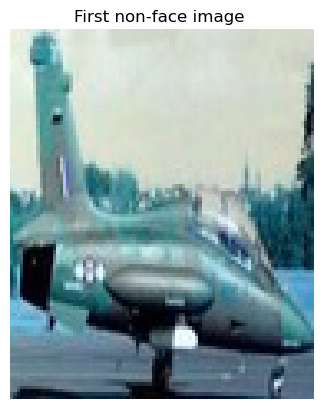

In [6]:
# show the first non-face image
arr = cv2.imread('./nonface_images/s1/airplane_0000.jpg')
#display the image. 
plt.imshow(arr, cmap='gray')
plt.title('First non-face image ')
plt.axis('off') 
plt.show()

Loading Data into Matrices

In [21]:
# Path to the dataset folders
nonface_dataset_path = 'nonface_images'
face_dataset_path = 'images'

# Getting the list of directories in the dataset folders
nonface_dirs, face_dirs = os.listdir( nonface_dataset_path ), os.listdir( face_dataset_path )

# Initializing the data and labels
nonface_data, face_data = np.zeros( (400,10304) ), np.zeros( (400,10304) )
nonface_labels, face_labels = np.zeros( (400,1) ), np.ones( (400,1) )

# Loading face data
cnt = 0
paths = ["images/s" + str(i) for i in range(1,41)]
for path in paths:
    files = os.listdir( path )
    for file in files:
        img = Image.open( path + "/" + file )
        np_img = np.array( img ) 
        np_img = np_img.flatten() 
        face_data[cnt] = np_img 
        cnt += 1

# Loading nonface data
cnt = 0
paths = ["nonface_images/s" + str(i) for i in range(1,9)]
for path in paths:
    files = os.listdir( path )
    for file in files:
        img = Image.open( path + "/" + file )
        np_img = np.array( img )
        np_img = np_img.mean(axis=2) 
        np_img = np_img.flatten()
        nonface_data[cnt] = np_img
        cnt += 1

# Shuffling (mix) the data
np.random.shuffle( face_data )
np.random.shuffle( nonface_data )

In [22]:
def process_splits(face_data, nonface_data, face_labels, nonface_labels, nonface_cnt=len(nonface_data)):

    nonface_data = nonface_data[ 0 : nonface_cnt ]
    data = np.append( face_data, nonface_data, axis=0 )
    labels = np.append( face_labels, nonface_labels, axis=0 )

    # Training set ==> odd (start from 1 , step by 2)
    training_set = data[ 1 : len(data) : 2 ]
    training_labels = labels[ 1 : len(data) : 2 ]

    # Testing set ==> even (start from 2 , step by 2)
    test_set = data[ 0 : len(data) : 2 ]
    test_labels = labels[ 0 : len(data) : 2 ]

    return training_set, test_set, training_labels, test_labels

In [ ]:
def process_data_PCA(training_set, test_set):

    # Computing the mean of the training set
    means = np.mean( training_set, axis=0 )
    # We need to reshape the means vector to be a row vector (tarspose) to be able to broadcast it with the training set and test set
    means = means.reshape( 1, 10304 )

    # Centering the data
    # We center the test set with the mean of the training set to keep the same distribution
    centered_training_set = training_set - means
    centered_test_set = test_set - means

    covariance_matrix = np.cov( centered_training_set.T, bias=True )
    
    # get eigen values 
    eigenvalues, eigenvectors = np.linalg.eigh( covariance_matrix )

    # Sorting the eigenvalues with their corresponding eigenvectors in descending order
    positions = eigenvalues.argsort()[::-1]
    sorted_eigenvalues = ( eigenvalues[positions] )
    sorted_eigenvectors = ( eigenvectors[:, positions] )
        
    return sorted_eigenvalues, sorted_eigenvectors, centered_training_set, centered_test_set

In [11]:
def PCA(eigenvalues, eigenvectors, alpha):
    total = sum( eigenvalues )

    #r ==> the number of eigenvectors we need to keep to keep alpha of the original variance
    r = 0
    current_sum = 0
    # We iterate until we reach maximum value of r (until the cumulative variance (count) equal or more alpha).
    while (current_sum / total) < alpha:
        current_sum += eigenvalues[ r ]
        r += 1
    
    # We only keep the first r eigenvectors (the ones with the highest eigenvalues)
    new_space = eigenvectors[:, :r]
    return new_space

In [13]:
from sklearn.neighbors import KNeighborsClassifier

pca_scores = []
alpha = 0.8

for nonface_cnt in range( 50, len(nonface_data) + 1, 50 ):
    
    print( '[PCA] Running for', nonface_cnt, 'non-face images\n', nonface_cnt // 2, '-> training\n', nonface_cnt // 2, '-> test' )

    # Splitting the data into training and test sets
    training_set, test_set, training_labels, test_labels = process_splits( face_data, nonface_data, face_labels, nonface_labels, nonface_cnt )
    
    # Processing the data for PCA and projecting it onto the new space using the best alpha
    sorted_eigenvalues, sorted_eigenvectors, centered_training_set, centered_test_set = process_data_PCA( training_set, test_set )
    new_space = PCA( sorted_eigenvalues, sorted_eigenvectors, alpha )

    # Projecting the training set and test set onto the new space
    new_training_set = np.dot( centered_training_set, new_space )
    new_test_set = np.dot( centered_test_set, new_space )

    # Training the model
    knn = KNeighborsClassifier( n_neighbors=1 )
    knn.fit( new_training_set, training_labels.ravel() )

    # Testing the model and calculating the accuracy
    score = knn.score( new_test_set, test_labels.ravel() )
    pca_scores.append( (nonface_cnt, score) )

    print( '[PCA] Accuracy for', nonface_cnt, 'non-face images =', '{:.2f}%'.format(score * 100))
    print( '----------------------------------------', end='\n\n')

[PCA] Running for 50 non-face images
 25 -> training
 25 -> test
[PCA] Accuracy for 50 non-face images = 95.11%
----------------------------------------

[PCA] Running for 100 non-face images
 50 -> training
 50 -> test
[PCA] Accuracy for 100 non-face images = 95.20%
----------------------------------------

[PCA] Running for 150 non-face images
 75 -> training
 75 -> test
[PCA] Accuracy for 150 non-face images = 94.18%
----------------------------------------

[PCA] Running for 200 non-face images
 100 -> training
 100 -> test
[PCA] Accuracy for 200 non-face images = 93.67%
----------------------------------------

[PCA] Running for 250 non-face images
 125 -> training
 125 -> test
[PCA] Accuracy for 250 non-face images = 93.54%
----------------------------------------

[PCA] Running for 300 non-face images
 150 -> training
 150 -> test
[PCA] Accuracy for 300 non-face images = 94.29%
----------------------------------------

[PCA] Running for 350 non-face images
 175 -> training
 175 

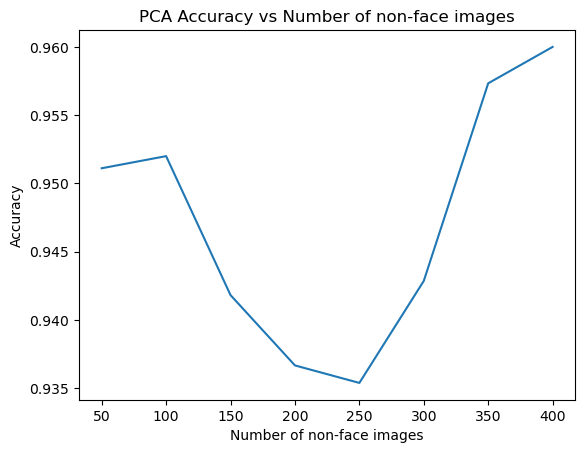

In [14]:
# plot accuracy vs number of non-face images
# pair[0] is the number of non-face images, pair[1] is the corresponding accuracy
plt.plot( [pair[0] for pair in pca_scores], [pair[1] for pair in pca_scores] )
plt.xlabel( 'Number of non-face images' )
plt.ylabel( 'Accuracy' )
plt.title( 'PCA Accuracy vs Number of non-face images' )
plt.show()

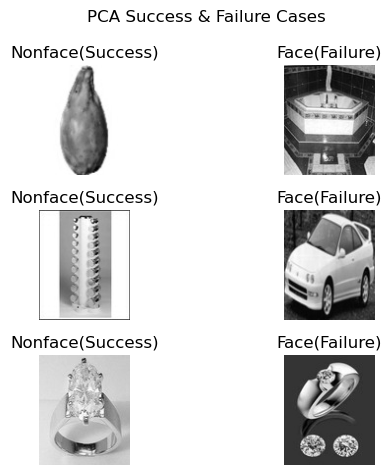

In [15]:
fig, axs = plt.subplots( 3, 2 )
success_count = 0
failure_count = 0

while success_count < 3 or failure_count < 3:

    # We randomly choose an image from the test set
    idx = np.random.randint( 0, len(test_set) - 1 )

    # We predict the label of the image
    prediction = knn.predict( new_test_set[idx].reshape( 1, -1 ) )

    # We plot 3 success cases and 3 failure cases. Success cases are on the left and failure cases are on the right
    if prediction == test_labels[idx]:
        if success_count == 3: continue
        i, j = success_count, 0
        success_count += 1

    elif failure_count < 3:
        i , j = failure_count, 1
        failure_count += 1
    
    else:
        continue

    axs[i, j].imshow( test_set[idx].reshape( 112, 92 ), cmap='gray' )
    axs[i, j].set_title( ('Face' if prediction == 1 else 'Nonface') + ('(Failure)' if prediction != test_labels[idx] else '(Success)') )
    axs[i, j].axis( 'off' )

fig.suptitle( 'PCA Success & Failure Cases' )
fig.tight_layout()
plt.show()

In [17]:
def LDA( training_set, h=False ):

    faces = training_set[ 0 : len(face_labels) // 2 ]
    nonfaces = training_set[ len(face_labels) // 2 : len(training_set) ]

    # Calculating the means of class-specific data (faces and non-faces)
    face_means = np.mean( faces, axis=0 )
    nonface_means = np.mean( nonfaces, axis=0 )

    # Reshaping to keep the dimensions consistent
    face_means = face_means.reshape( 1, 10304 )
    nonface_means = nonface_means.reshape( 1, 10304 )

    # Calculating the between-class scatter matrix
    B = np.dot( (face_means - nonface_means).T, (face_means - nonface_means) )

    # Centering the data
    centered_face_data = faces - face_means
    centered_nonface_data = nonfaces - nonface_means

    # Class scatter matrices
    Z1 = np.dot( centered_face_data.T, centered_face_data )
    Z2 = np.dot( centered_nonface_data.T, centered_nonface_data )

    # Calculating the within-class scatter matrix
    S = Z1 + Z2

    # Calculating the eigenvalues and eigenvectors of the covariance matrix of the training set
    # If h is True, we use the Hermitian version (eigh), otherwise we use the regular version (eig)
    if h == True:
        eigenvalues, eigenvectors = np.linalg.eigh( np.dot( np.linalg.inv(S), B ) )
    else:
        eigenvalues, eigenvectors = np.linalg.eig( np.dot( np.linalg.inv(S), B ) )

        eigenvalues = np.real( eigenvalues )
        eigenvectors = np.real( eigenvectors )

    # Sorting the eigenvectors in descending order of their corresponding eigenvalues
    positions = eigenvalues.argsort()[::-1]
    sorted_eigenvectors = ( eigenvectors[:, positions] )

    # Calculating the new space
    # Since we have 2 classes, we only need 1 dominant eigenvector
    new_space = sorted_eigenvectors[:, :1]

    return new_space

In [18]:
scores = []

for nonface_cnt in range( 50, len(nonface_data) + 1, 50 ):
    
    print( '[LDA] Running for', nonface_cnt, 'non-face images\n', nonface_cnt // 2, '-> training\n', nonface_cnt // 2, '-> test' )
    print( '----------------------------------------' )

    #splitting the data into training and test sets 
    training_set, test_set, training_labels, test_labels = process_splits( face_data, nonface_data, face_labels, nonface_labels, nonface_cnt )
    
    # Calculating the new space using LDA
    new_space = LDA( training_set, h=True )

    # Centering the training set and test set
    centered_training_set = training_set - np.mean( training_set, axis=0 )
    centered_test_set = test_set - np.mean( test_set, axis=0 )

    # Projecting the training set and test set onto the new space
    new_training_set = np.dot( centered_training_set, new_space ) # ==> centered_training_set . new_space
    new_test_set = np.dot( centered_test_set, new_space )

    # applying knn classifier
    knn = KNeighborsClassifier( n_neighbors=1 )
    knn.fit( new_training_set, training_labels.ravel() )

    # predicting results
    score = knn.score( new_test_set, test_labels.ravel() )
    
    #appending the score
    scores.append( score )

    print( '[LDA] Accuracy for', nonface_cnt, 'non-face images =', '{:.2f}%\n'.format(score * 100))

[LDA] Running for 50 non-face images
 25 -> training
 25 -> test
----------------------------------------
[LDA] Accuracy for 50 non-face images = 92.00%

[LDA] Running for 100 non-face images
 50 -> training
 50 -> test
----------------------------------------
[LDA] Accuracy for 100 non-face images = 91.20%

[LDA] Running for 150 non-face images
 75 -> training
 75 -> test
----------------------------------------
[LDA] Accuracy for 150 non-face images = 82.91%

[LDA] Running for 200 non-face images
 100 -> training
 100 -> test
----------------------------------------
[LDA] Accuracy for 200 non-face images = 84.67%

[LDA] Running for 250 non-face images
 125 -> training
 125 -> test
----------------------------------------
[LDA] Accuracy for 250 non-face images = 83.08%

[LDA] Running for 300 non-face images
 150 -> training
 150 -> test
----------------------------------------
[LDA] Accuracy for 300 non-face images = 81.43%

[LDA] Running for 350 non-face images
 175 -> training
 175 

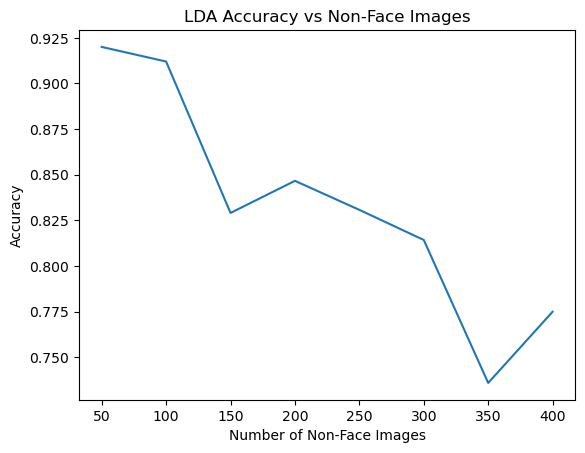

In [19]:
plt.plot( range( 50, len(nonface_data) + 1, 50 ), scores )
plt.xlabel( 'Number of Non-Face Images' )
plt.ylabel( 'Accuracy' )
plt.title( 'LDA Accuracy vs Non-Face Images' )
plt.show()

we conclude that accuracy decreased by increasing the number of non face image

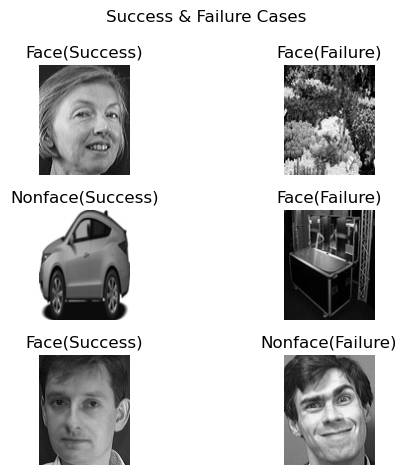

In [20]:
fig, axs = plt.subplots( 3, 2 )
success_count = 0
failure_count = 0

while success_count < 3 or failure_count < 3:

    # We randomly choose an image from the test set
    idx = np.random.randint( 0, len(test_set) - 1 )

    #predict the label of the image
    prediction = knn.predict( new_test_set[idx].reshape( 1, -1 ) )

    #plot 3 success cases and 3 failure cases. 
    if prediction == test_labels[idx]:
        if success_count == 3: continue
        i, j = success_count, 0
        success_count += 1

    elif failure_count < 3:
        i , j = failure_count, 1
        failure_count += 1
    
    else:
        continue

    axs[i, j].imshow( test_set[idx].reshape( 112, 92 ), cmap='gray' )
    axs[i, j].set_title( ('Face' if prediction == 1 else 'Nonface') + ('(Failure)' if prediction != test_labels[idx] else '(Success)') )
    axs[i, j].axis( 'off' )

fig.suptitle( 'Success & Failure Cases' )
fig.tight_layout()
plt.show()